# Aligned SOMs Evaluation on 10 Clusters Dataset

**Authors:**   
Markus Kiesel (01228952)   
Alexander Melem(11809621)   
Laurenz Ruzicka (01619916)   

In [1]:
import os, sys
import numpy as np

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
  sys.path.append(module_path)

from src.data import load_dataset
from src.config import config
from src.aligned_som import AlignedSom
from src.visualize import plot_aligned_som, HitHist, UMatrix

DATASET_NAME = '10clusters'

In [2]:
def setup(som_dim, num_layers, aspect_selection,
          sigma=1.0,
          learning_rate=0.5,
          layer_distance_ratio=0.1,
          num_plots=5,
          train_steps_by_layer=1000,
          random_seed=config.SEED,
          load_existing=True):

    input_data, components, weights, classinfo = load_dataset(DATASET_NAME)
    data = input_data['arr']
    aspect_selection = np.array(aspect_selection)
   
    asom = AlignedSom(
        som_dim, data, aspect_selection,
        num_layers=num_layers,
        sigma=sigma,
        learning_rate=learning_rate,
        layer_distance_ratio=layer_distance_ratio,
        random_seed=random_seed)
    
    os.makedirs("../results", exist_ok=True)
    
    if load_existing and os.path.exists(f"../results/{DATASET_NAME}_setup_{som_dim[0]}_{som_dim[1]}_{num_layers}_{sigma}_{layer_distance_ratio}_{learning_rate}_{'-'.join([str(c) for c in aspect_selection])}.npy"):
        asom.set_layer_weights(np.load(f"../results/{DATASET_NAME}_setup_{som_dim[0]}_{som_dim[1]}_{num_layers}_{sigma}_{layer_distance_ratio}_{learning_rate}_{'-'.join([str(c) for c in aspect_selection])}.npy"))
    else:
        asom.train(train_steps_by_layer * num_layers)
        np.save(f"../results/{DATASET_NAME}_setup_{som_dim[0]}_{som_dim[1]}_{num_layers}_{sigma}_{layer_distance_ratio}_{learning_rate}_{'-'.join([str(c) for c in aspect_selection])}.npy", np.array(asom.get_layer_weights()))
    
    fig = plot_aligned_som(asom, data, num_plots=num_plots, upscaling_factor=100)
    fig.savefig(f"../results/{DATASET_NAME}_setup_{som_dim[0]}_{som_dim[1]}_{num_layers}_{sigma}_{layer_distance_ratio}_{learning_rate}_{'-'.join([str(c) for c in aspect_selection])}.pdf")
    
    visualization_function = UMatrix
    fig_umatrix = plot_aligned_som(asom, data, num_plots=num_plots, upscaling_factor=100, visualization_function=visualization_function)
    fig_umatrix.savefig(f"../results/{DATASET_NAME}_setup_{visualization_function.__name__}_{som_dim[0]}_{som_dim[1]}_{num_layers}_{sigma}_{layer_distance_ratio}_{learning_rate}_{'-'.join([str(c) for c in aspect_selection])}.pdf")
    
    visualization_function = HitHist
    fig_hit = plot_aligned_som(asom, data, num_plots=num_plots, upscaling_factor=100, visualization_function=visualization_function)
    fig_hit.savefig(f"../results/{DATASET_NAME}_setup_{visualization_function.__name__}_{som_dim[0]}_{som_dim[1]}_{num_layers}_{sigma}_{layer_distance_ratio}_{learning_rate}_{'-'.join([str(c) for c in aspect_selection])}.pdf")
    
    return asom

# Dataset

>
> This artificial data set consists of data points arranged in 10 distinctive clusters. The clusters were generated from gaussian distributions, with different densities(standard deviations). The data set contains ten dimensions. 
>
> <cite> http://www.ifs.tuwien.ac.at/dm/somtoolbox/datasets.html

Since the dataset is an artificial dataset, we could not find a meaning split of aspects into two subgroups. Therefore, we focused on the interpretation of algorithmic parameters, instead of insights into the data itself. Since the goal of this task was to implement an aligned self-organizing map (ASOM), we excluded tests of standard SOM parameters, like different neighborhood functions, distance metrics, decay functions etc., which could be tuned by the used algorithm in future work.  

In [3]:
input_data, components, weights, classinfo = load_dataset('10clusters')
data = input_data['arr']
data.shape

(850, 10)

## 10x10 Aligned SOMs on 10 Clusters dataset

In [12]:
SOM_DIM = (10, 10)
N_LAYERS = 31
ASPECT_SELECTION = [1, 1, 1, 1, 1, 1, 1, 0, 0, 0]

### Default Setup

In order to see the influence different parameters have on the result, we first trained a small (10x10 units) baseline ASOM on the 10 clusters dataset. It has 31 layers and a layer distance ratio as given in the paper by Pampalk of 0.1. 

The plots for the baseline, as well as for the other visualizations, shows the normalized SDH with a factor of 2. The x-axis label specifies the weighting factor for both aspects at the depicted layer.

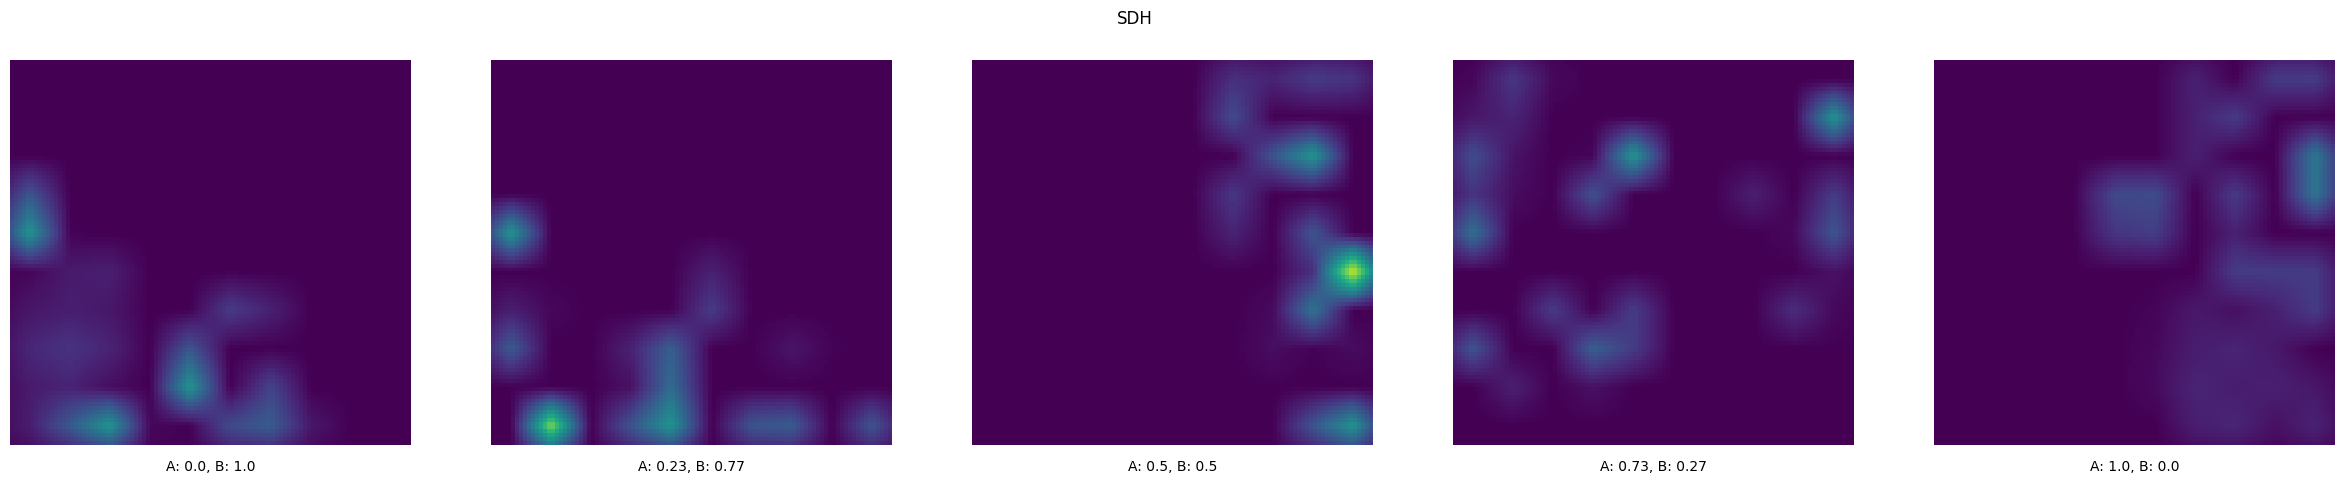

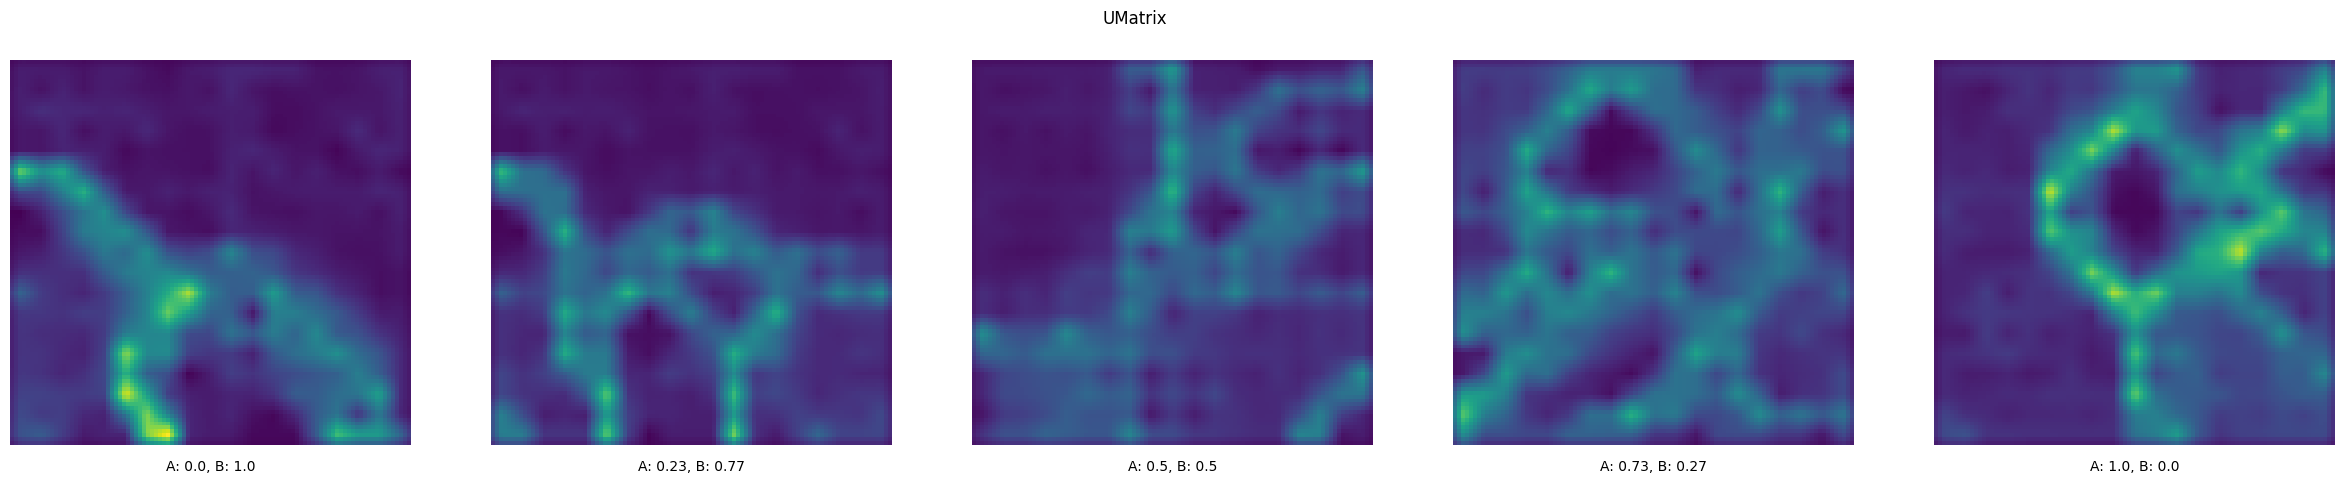

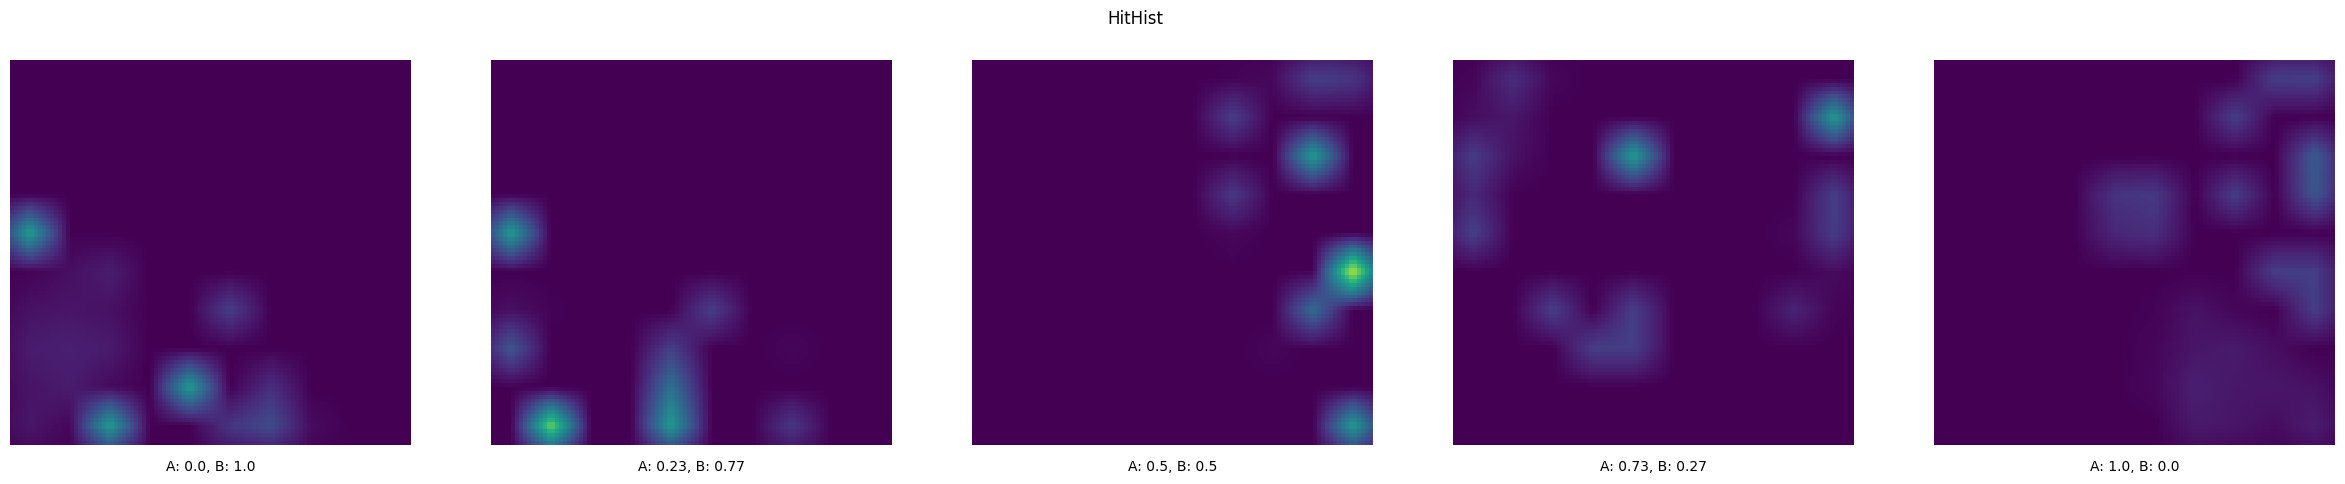

In [5]:
asom_small_1 = setup(
    som_dim=SOM_DIM,
    num_layers=N_LAYERS,
    aspect_selection=ASPECT_SELECTION)

### Many In-Between Layers

Our first experiment considered the influence many in-between layers have on the coupling of the layers. We suspected the the different number of in-between layers would strongly change the appearance of the ASOM. This is because close by layers in the baseline ASOM with 31 layers vary stronger in initialization, weighing and training than for the 128 layer ASOM, but the influence of them would be similar. The influence is similar, because the depth-wise decay of the neighborhood function is independent of the number of layers. 

This was found in the observations, where even the extreme cases of weighing (A = 0, B = 1 and the opposite) differed drastically.

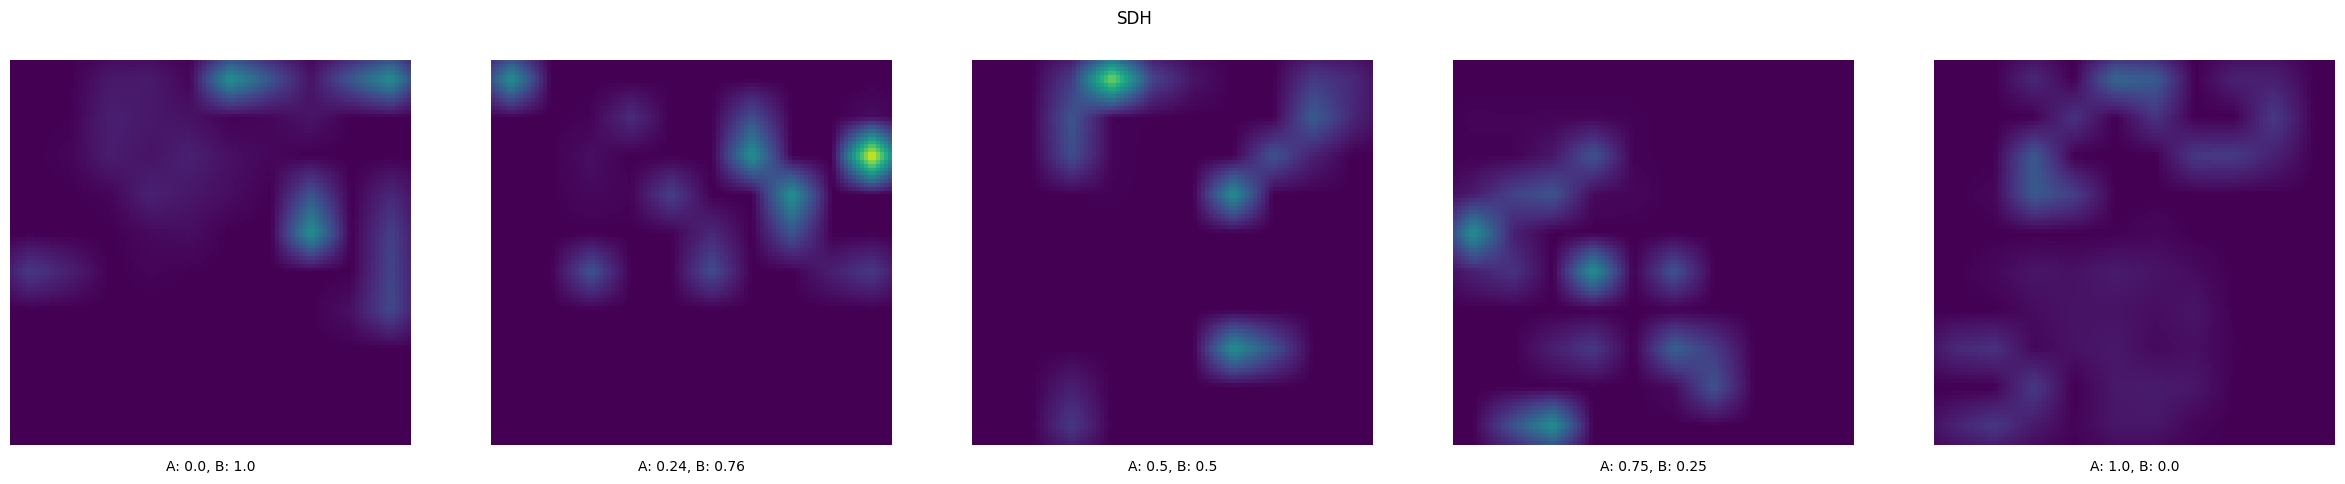

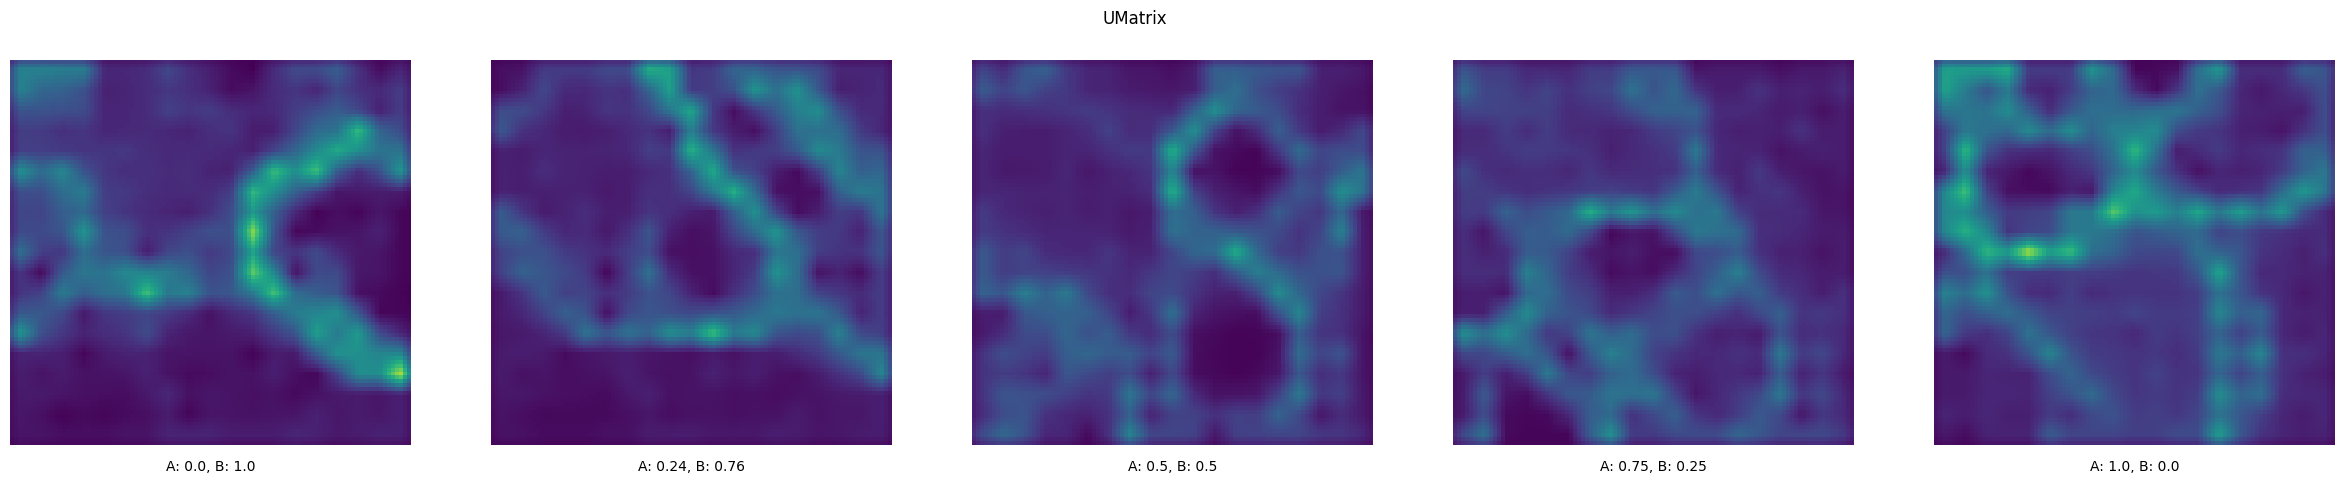

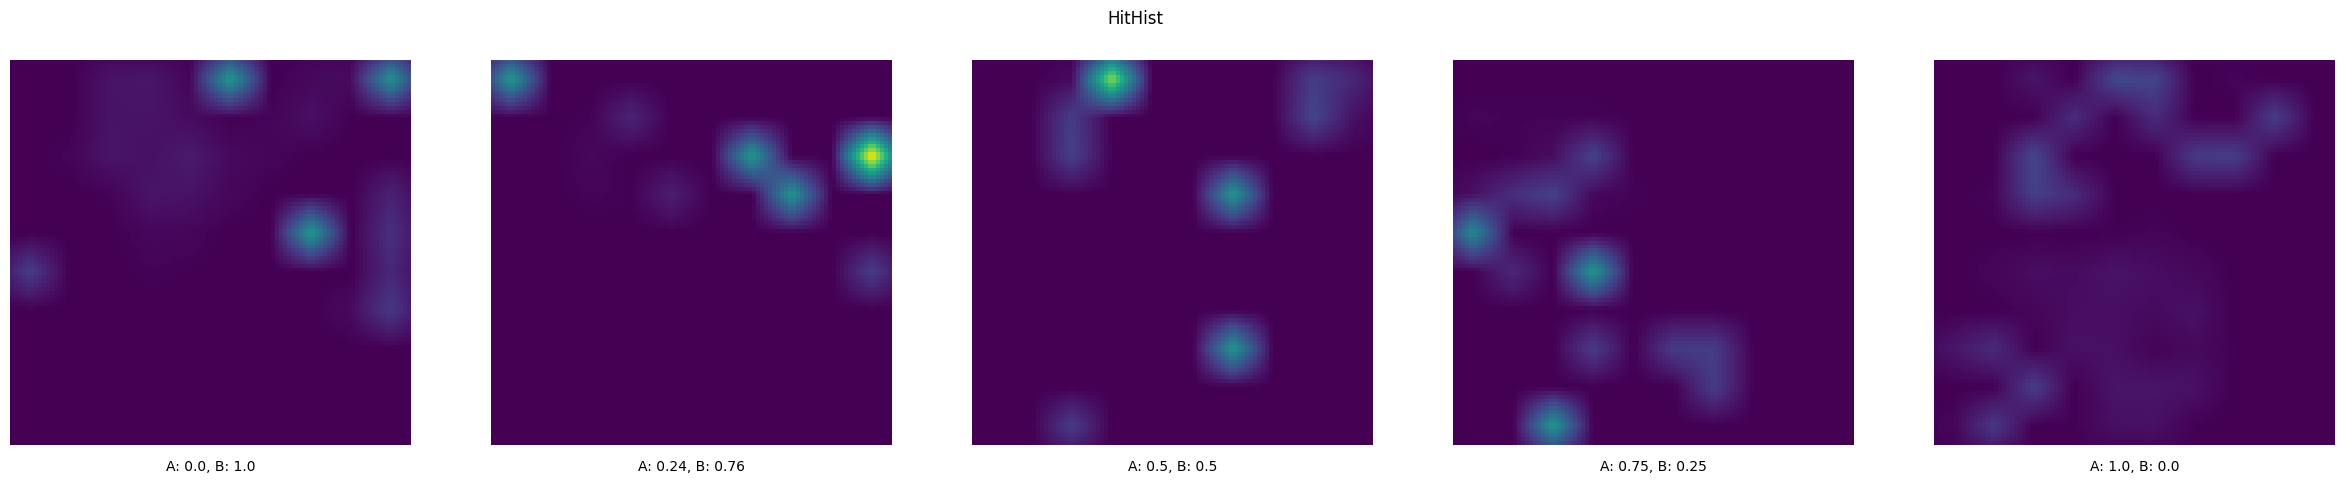

In [6]:
som_small_2 = setup(
    som_dim=SOM_DIM,
    num_layers=128,
    aspect_selection=ASPECT_SELECTION)

### Strong Layer-Wise Coupling

We suspect that a strong layer-wise coupling would lead to similar layers for neighboring aspect weights. We set the layer distance ratio to a very high value of 10, which means that a depth-wise connection is stronger than a connection inside a given layer. This would of course not be ideal for a real-world setting and can be seen as an algorithmic test-case. We would also expect to see a high degree of coupling in the layer-wise dimension, because especially in the later stage of training, the neighboring layers are stronger affected by an update of the winning unit at the selected layer than the selected layer itself. 




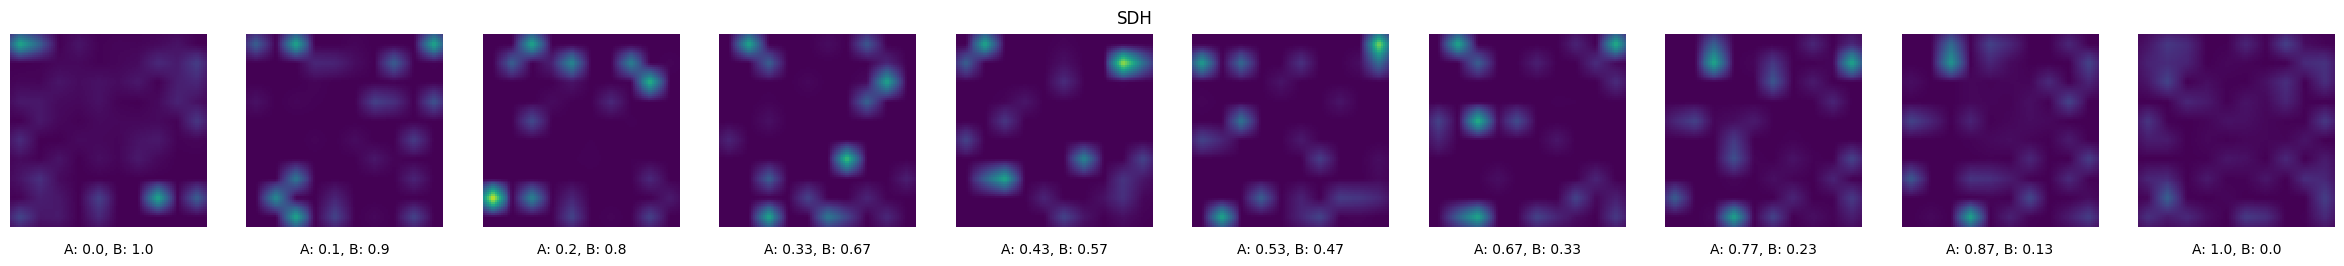

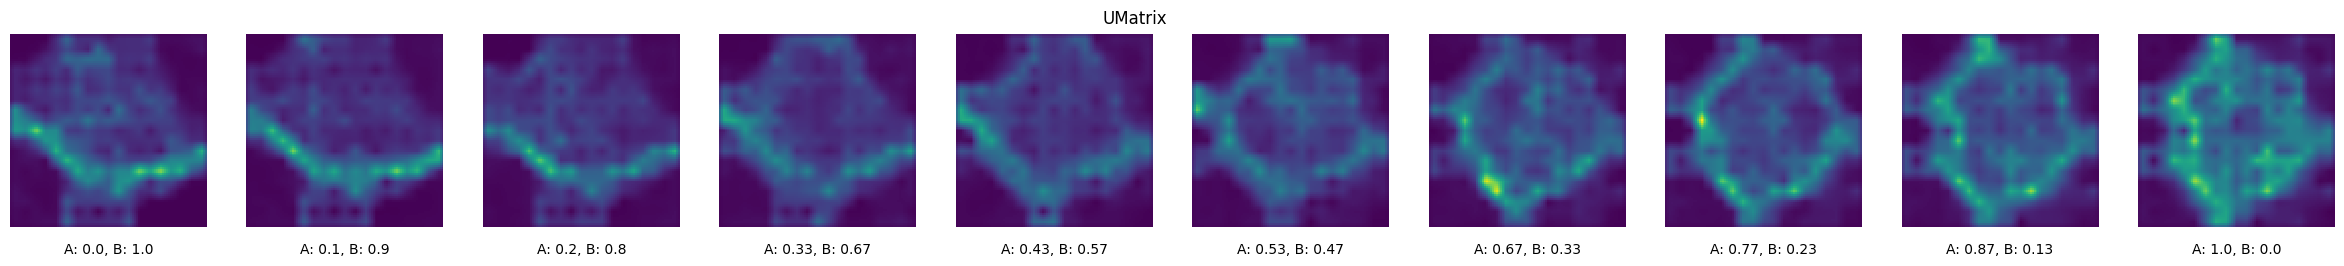

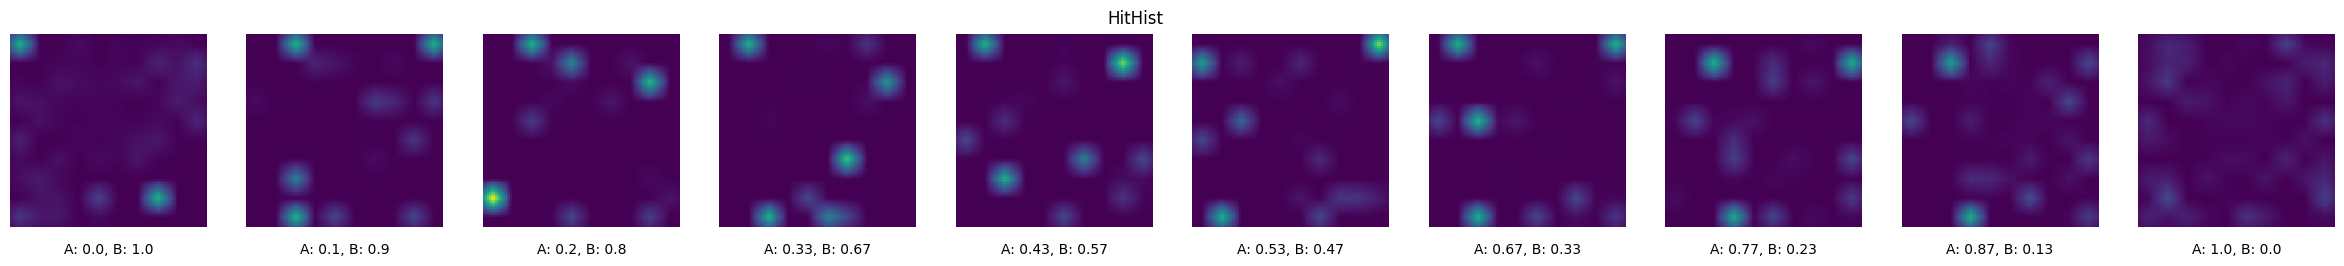

In [13]:
asom_small_3 = setup(
    som_dim=SOM_DIM,
    num_layers=N_LAYERS,
    aspect_selection=ASPECT_SELECTION,
    layer_distance_ratio=10,
    num_plots=10)

### Weak Layer-Wise Coupling

The weak layer-wise coupling is the counterpart to the strong layer-wise coupling. We expect to see and also find in the experiment, that the difference between neighboring layers is stronger. They are more decoupled, which can be seen especially prominent in the the U-Matrix. 

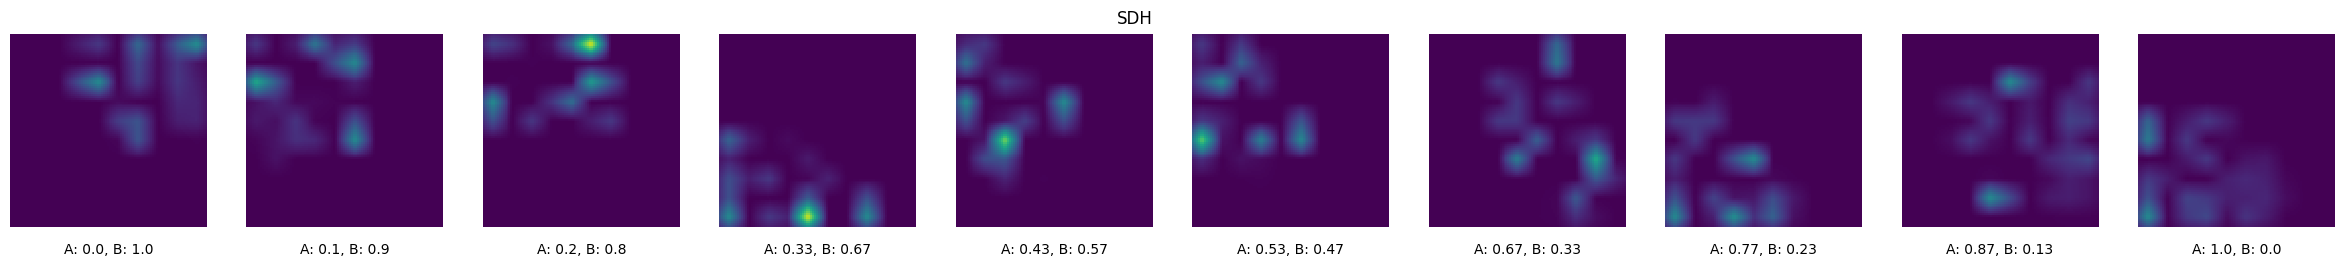

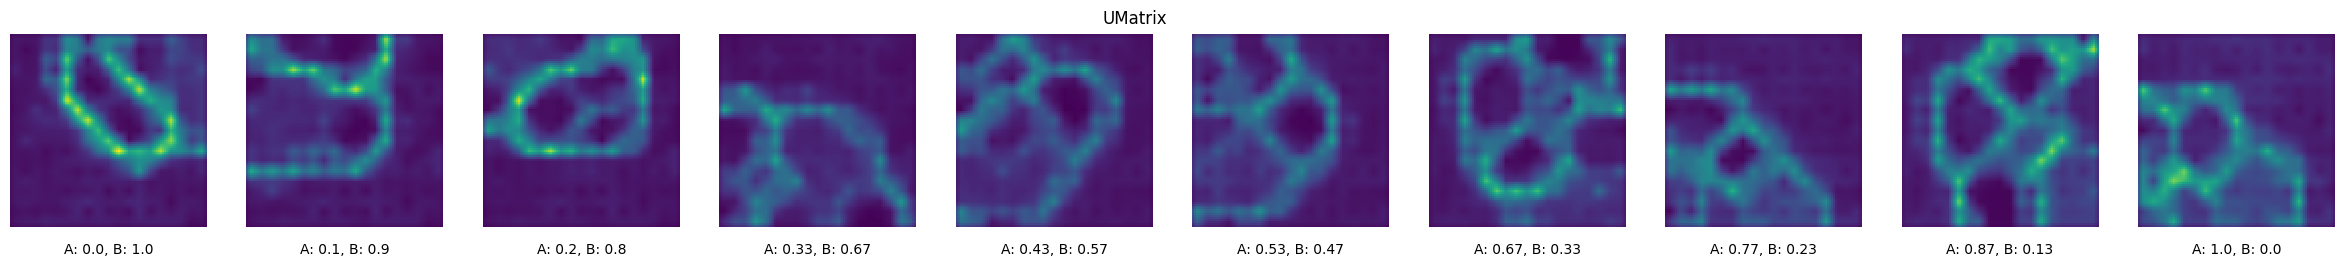

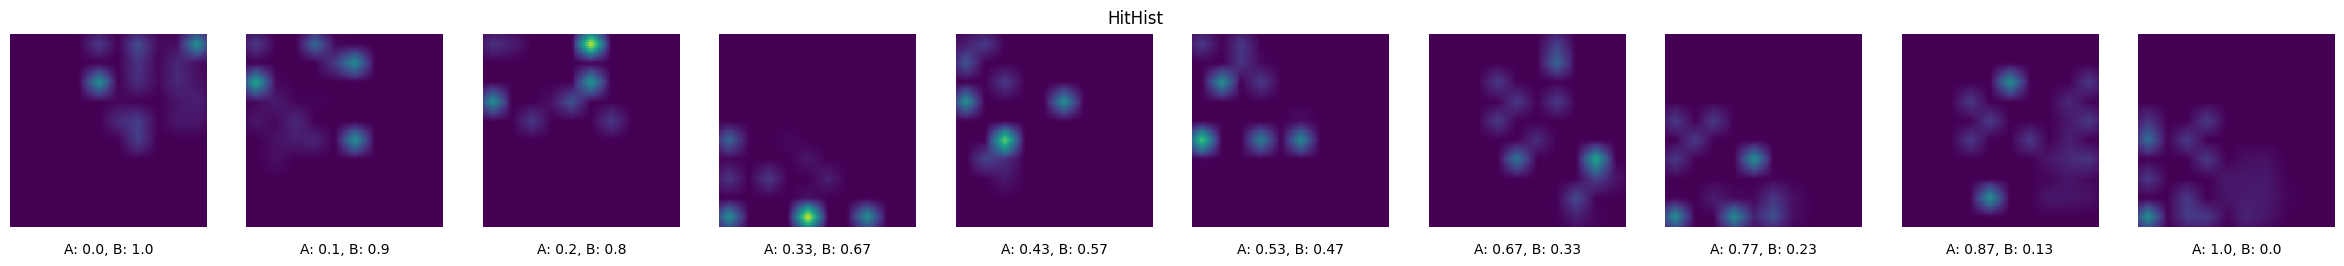

In [15]:
asom_small_4 = setup(
    som_dim=SOM_DIM,
    num_layers=N_LAYERS,
    aspect_selection=ASPECT_SELECTION,
    layer_distance_ratio=1e-3,
    num_plots=10)

### Few In-Between Layers

For this experiment, we reduced the number of layers. This induces a stronger layer-wise coupling, since the relative strength of the layer-wise neighboring function is increased. We therefore see clusters that stay consistent over a wider range of weighting parameters.

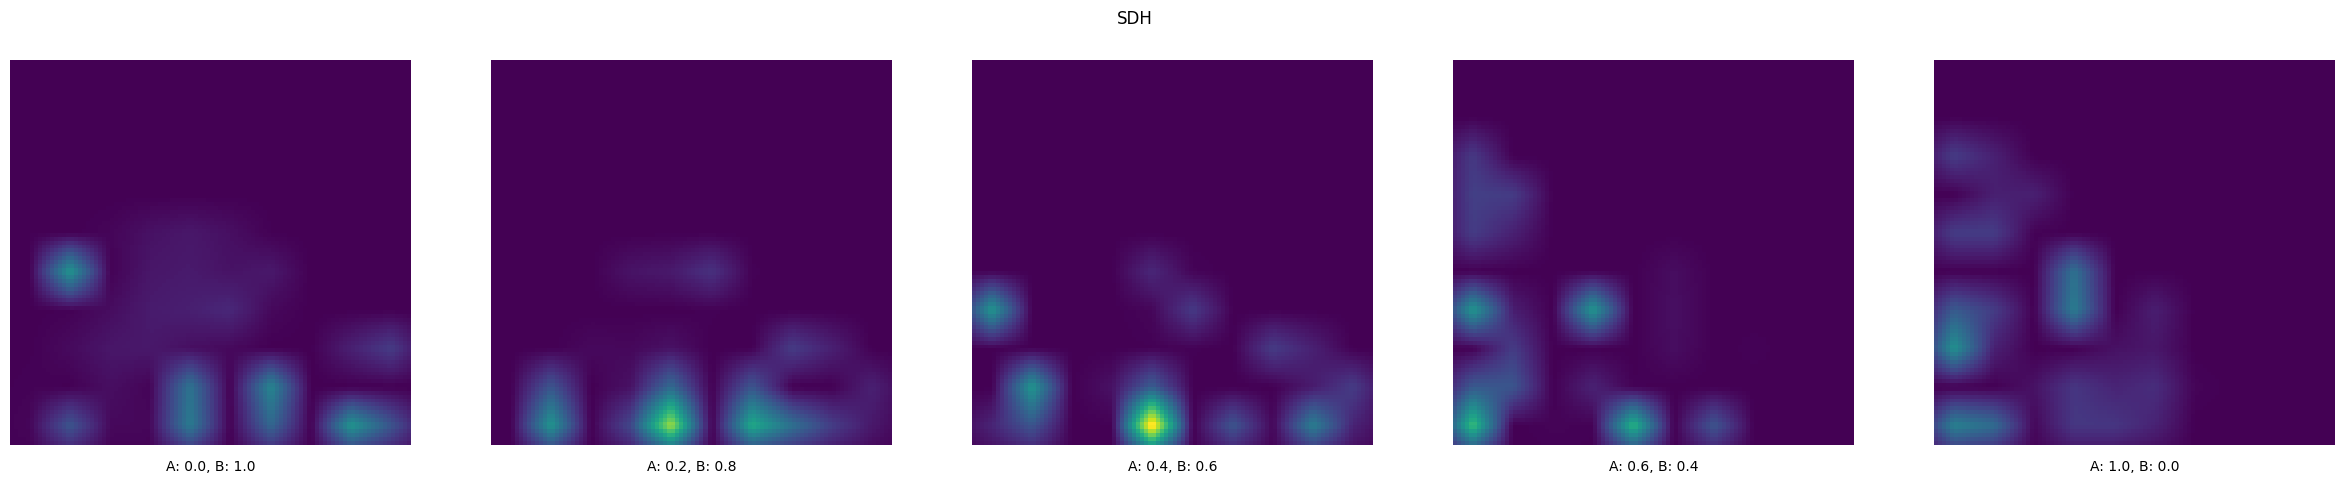

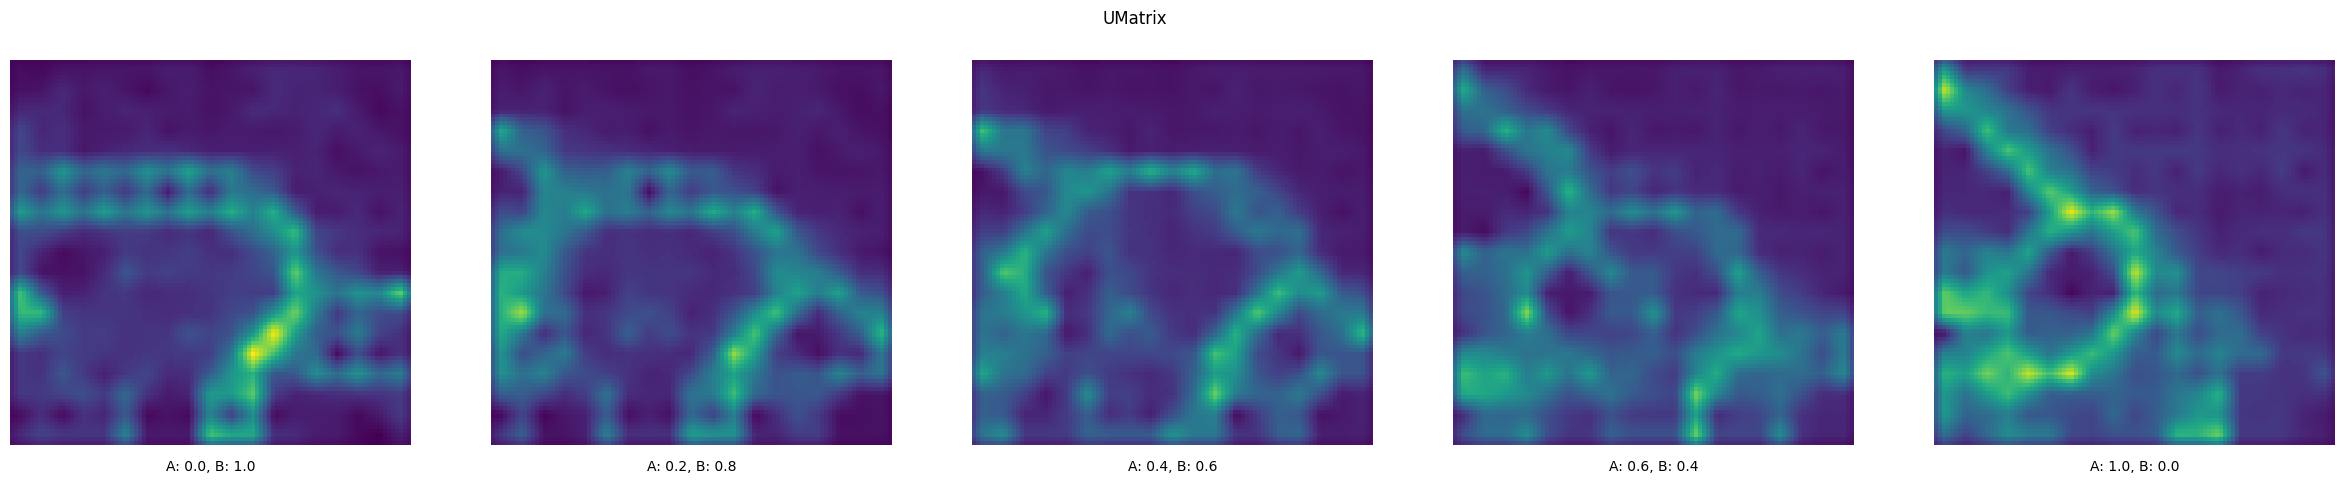

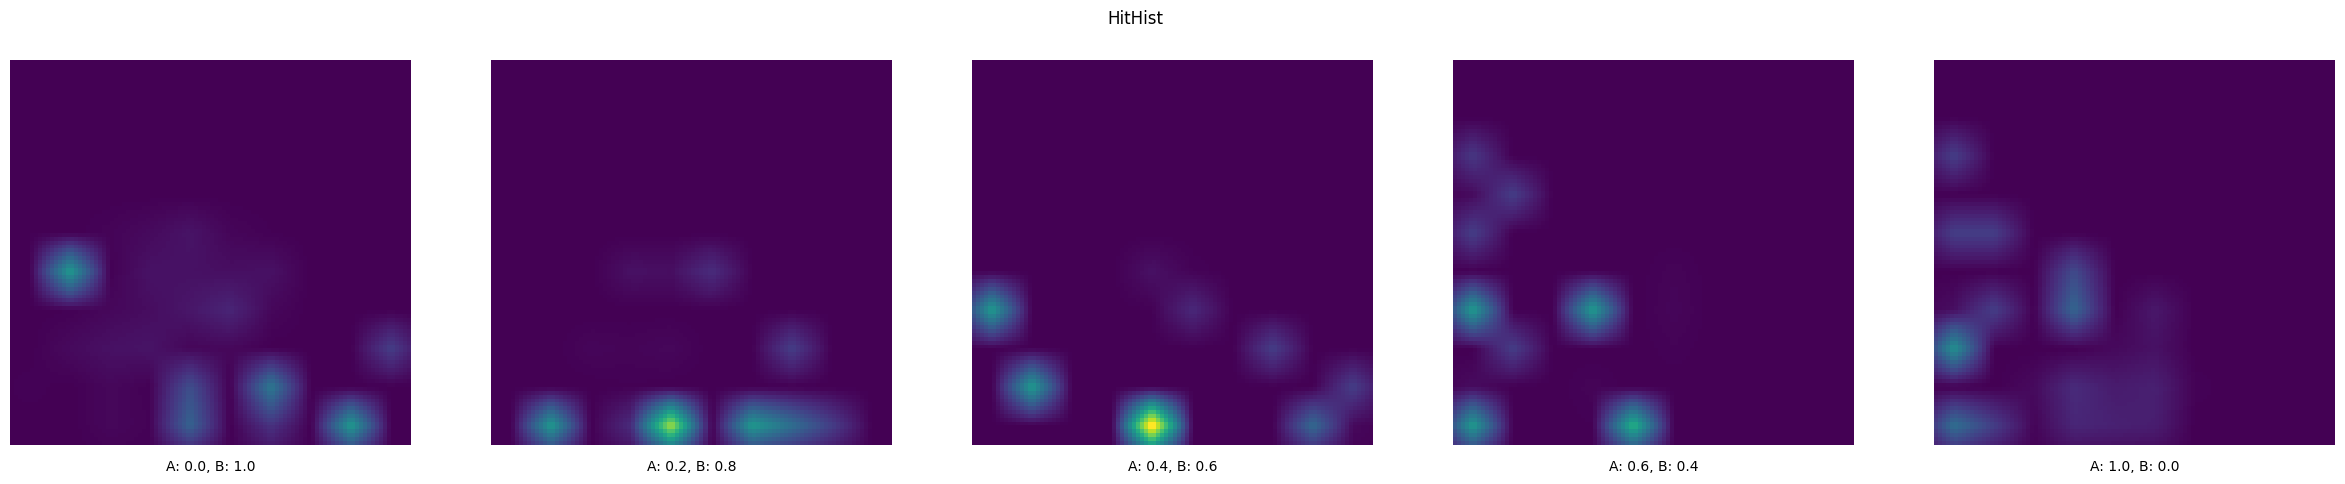

In [16]:
asom_small_5 = setup(
    som_dim=SOM_DIM,
    num_layers=6,
    aspect_selection=ASPECT_SELECTION)

### Switch Aspect Indices

With switched aspect indices we expect a similar outcome as in the baseline, with a inverted ordering of the layers. We were surprised to see that the randomized influence of drawing from the trainings data had such a strong impact.  

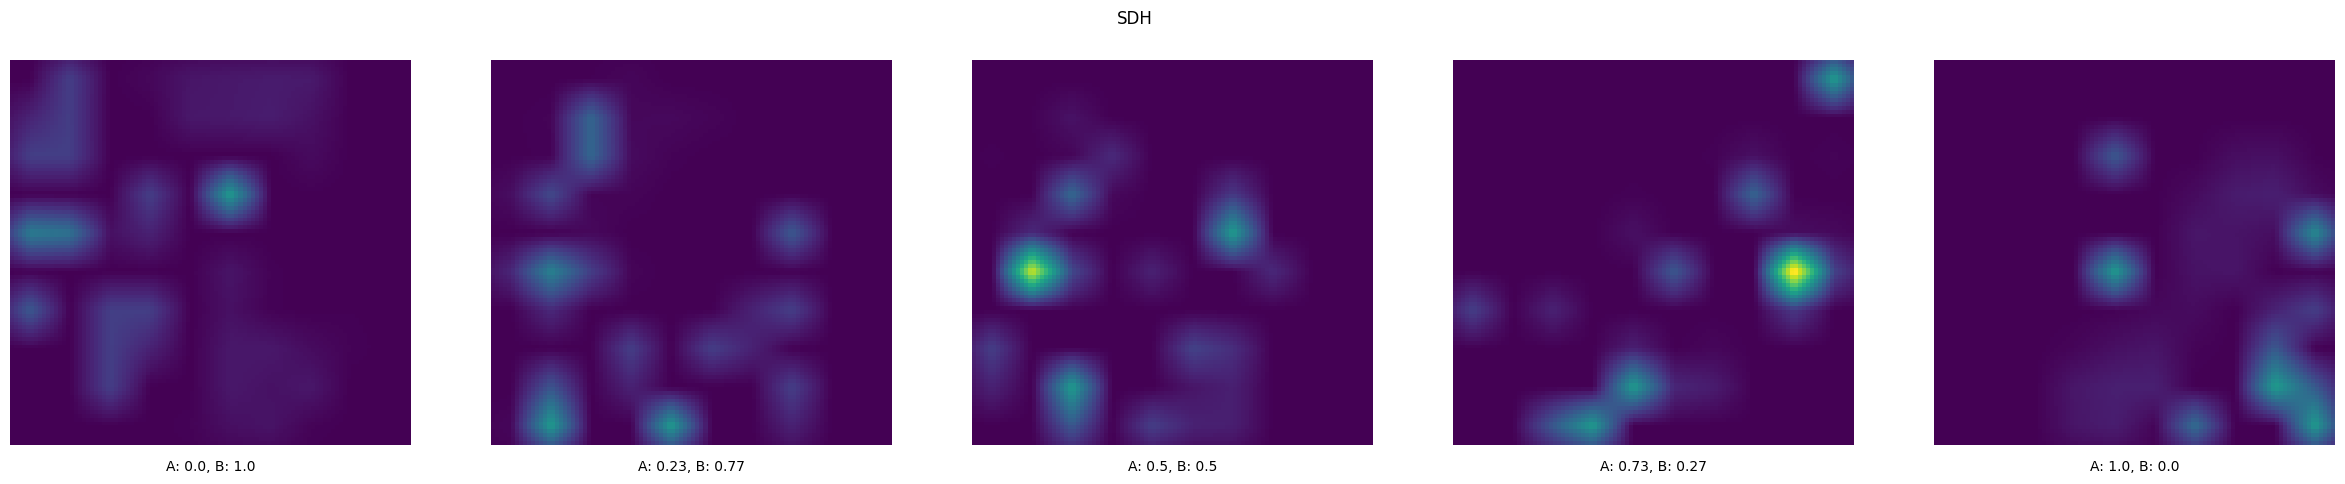

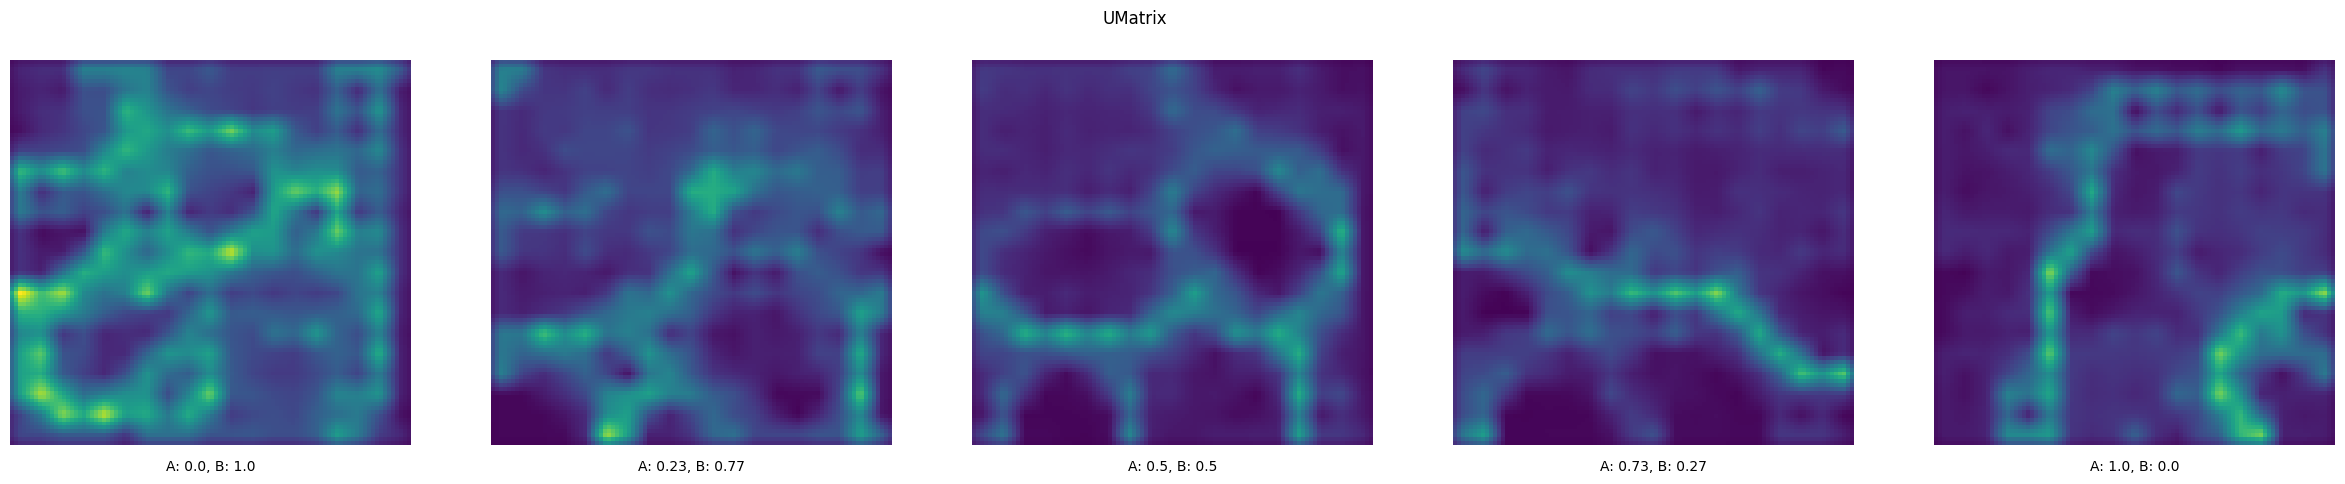

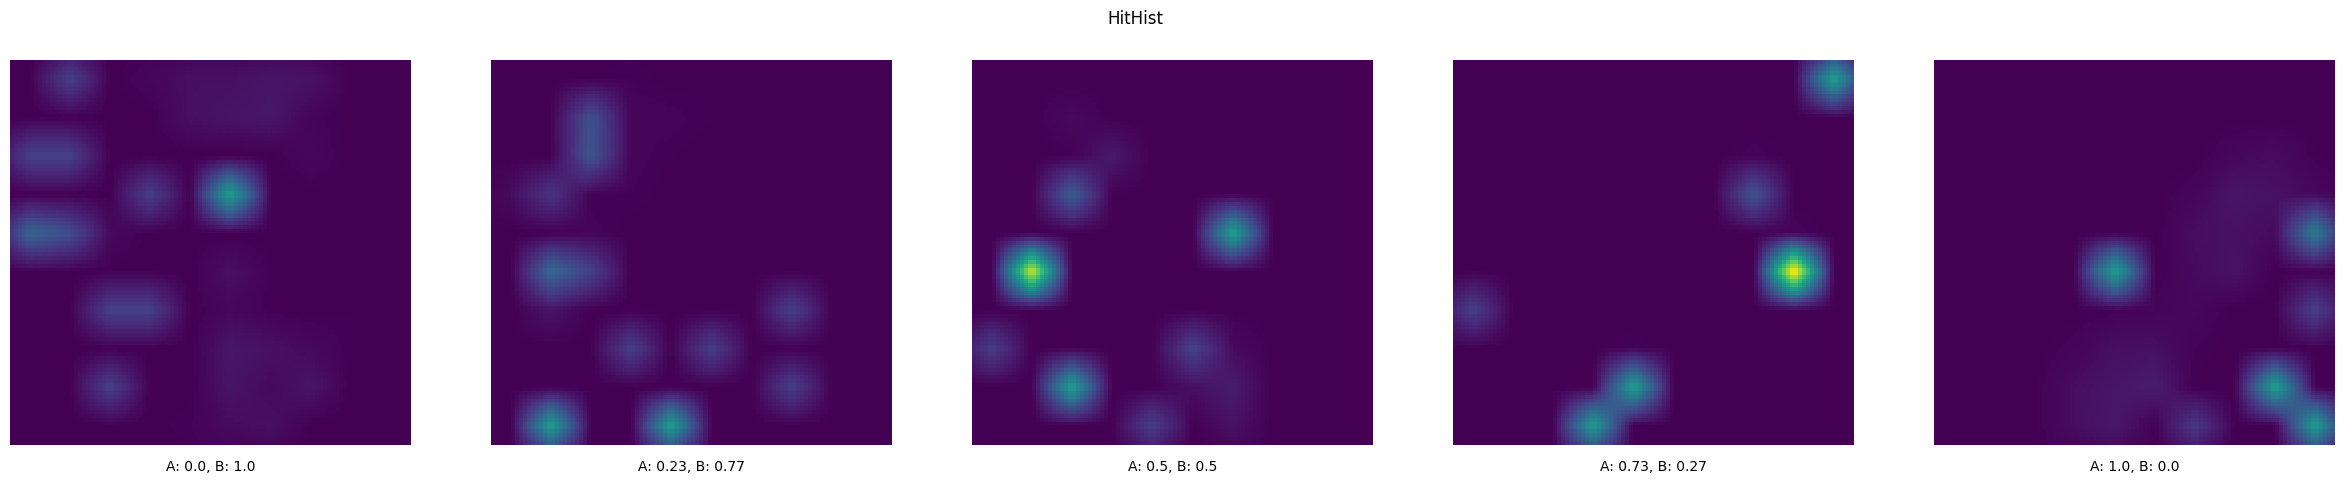

In [20]:
asom_small_6 = setup(
    som_dim=SOM_DIM,
    num_layers=N_LAYERS,
    aspect_selection=[0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

### Only Aspect B

This was a technical test to see how the ASOM would behave if all features are assigned to the same aspect. The rightmost image in the SDH and HiT show that all data points are scaled with the weight 0 and all weights of the SOM are scaled with 0, meaning that all are mapped to the same unit. This can also be seen in the U-Matrix, where the distances are all zero.

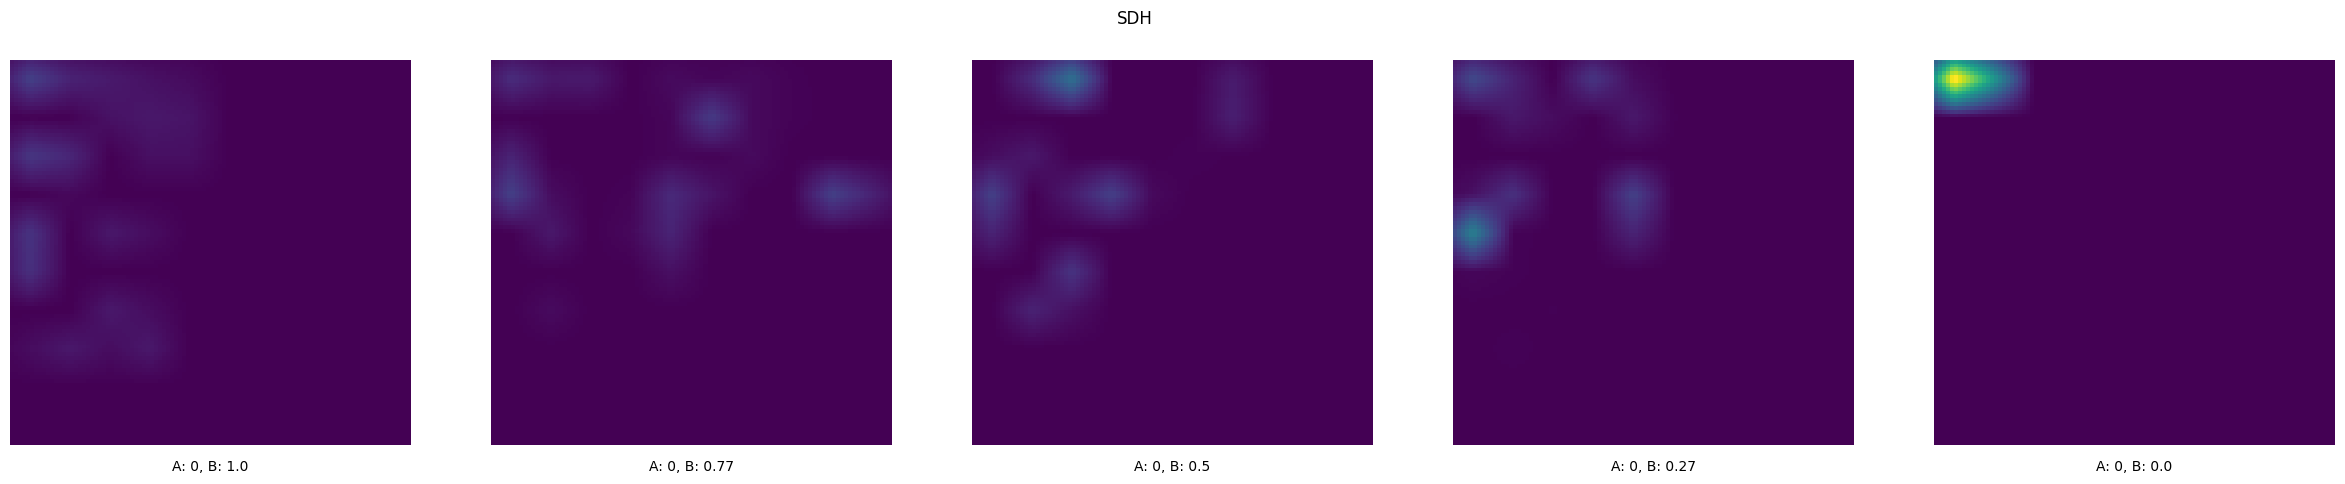

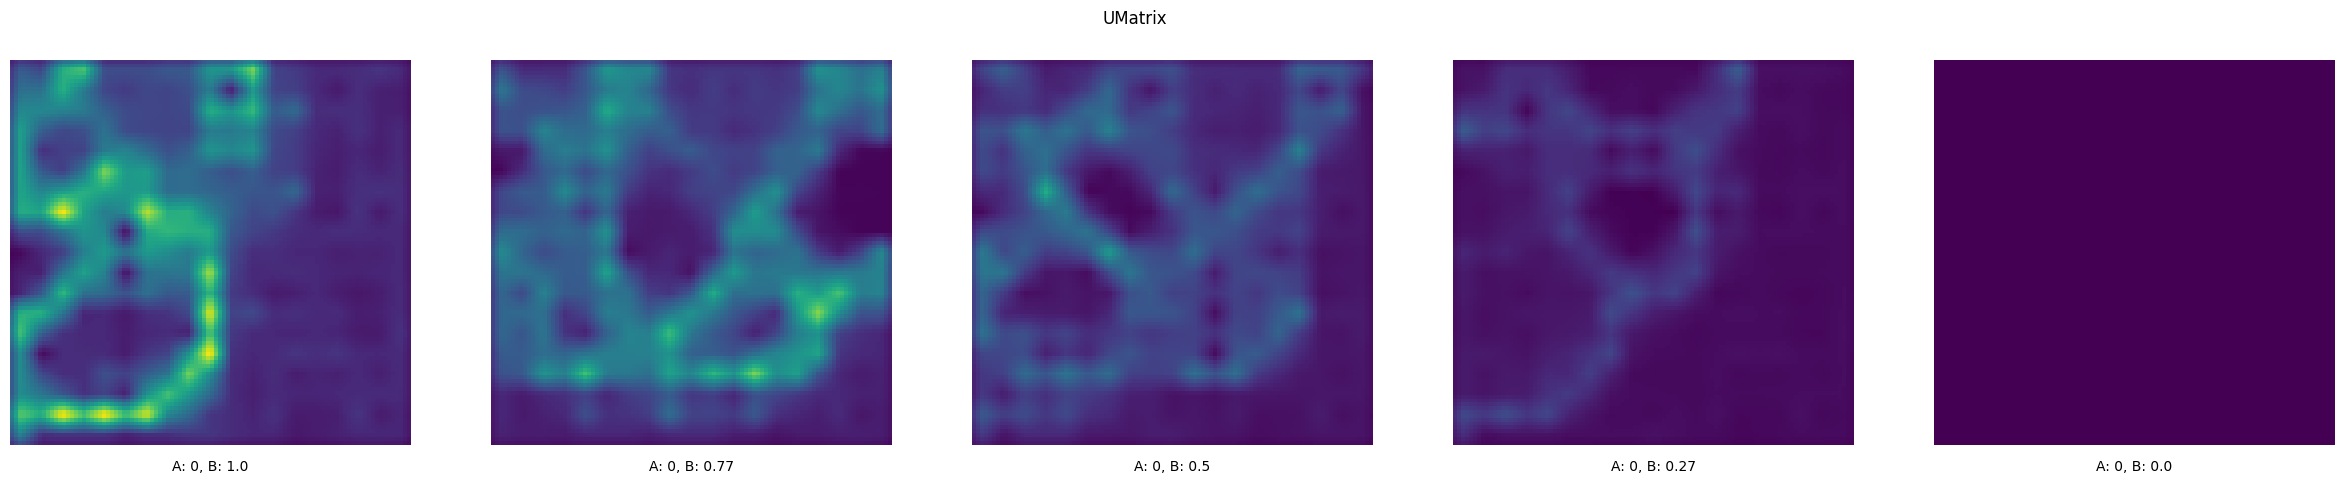

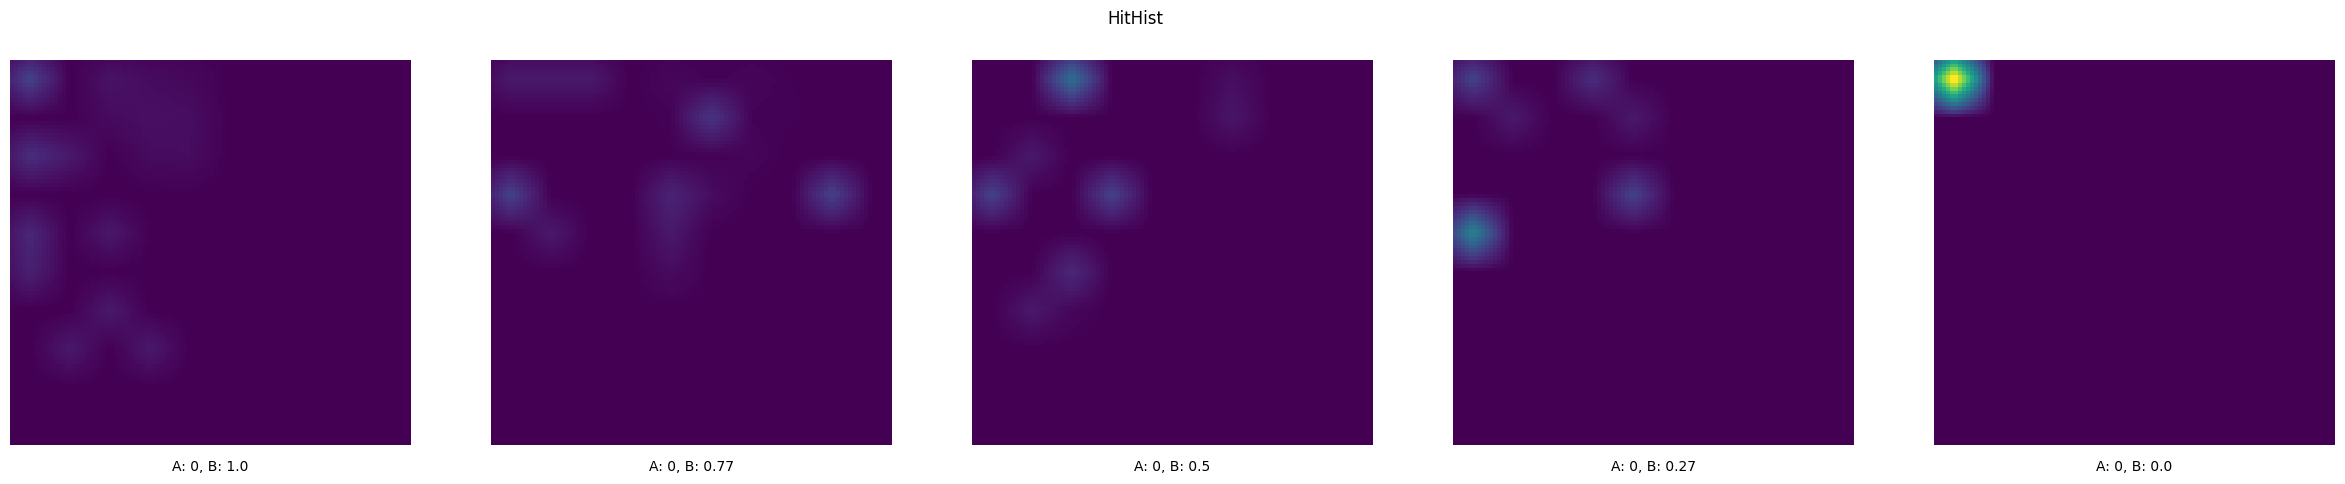

In [21]:
asom_small_7 = setup(
    som_dim=SOM_DIM,
    num_layers=N_LAYERS,
    aspect_selection=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Only Aspect  A

The counterpart experiment to only using aspect B. The same reasoning as above holds. Also, the behavior between the two ASOMs is similar (with stochastic differences because of the training)

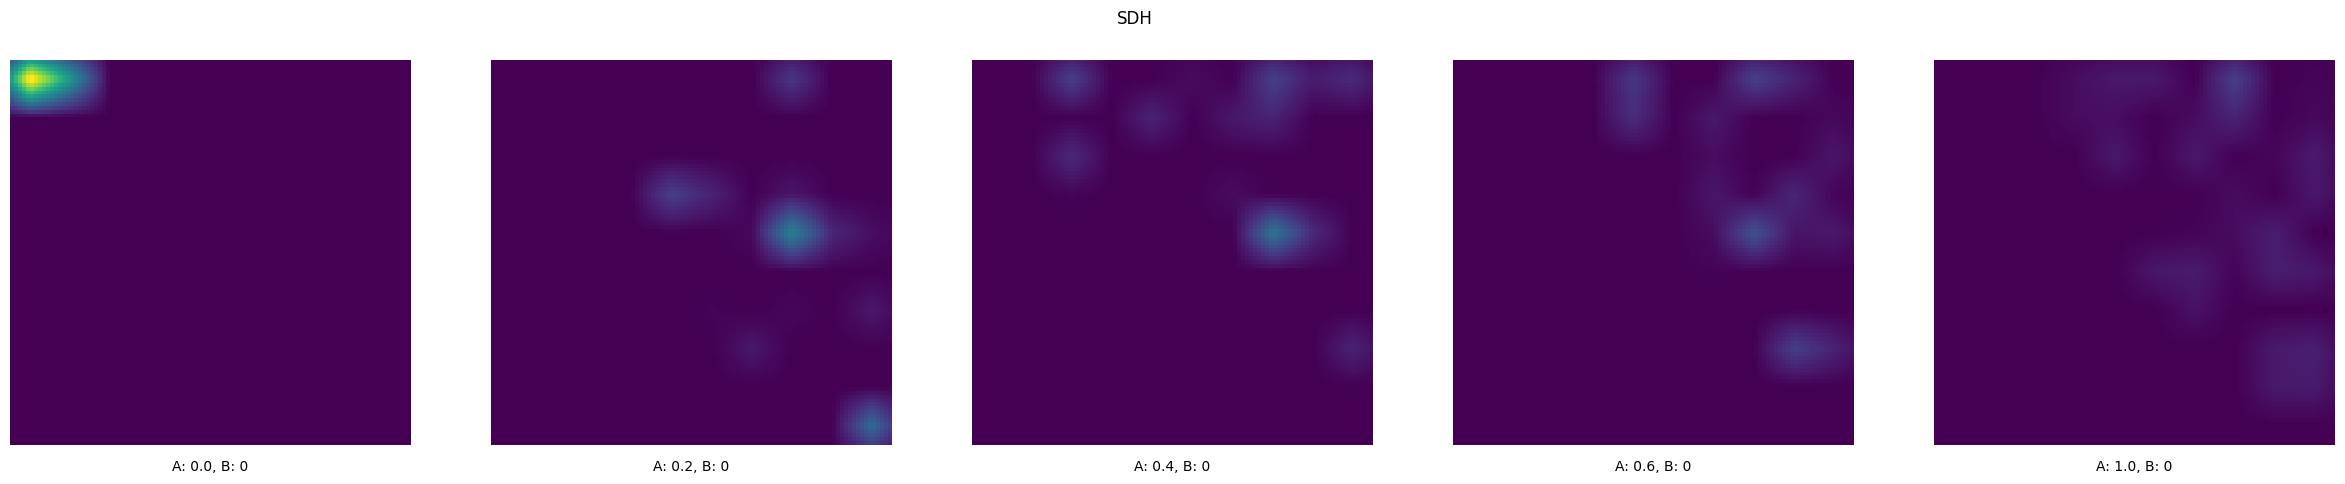

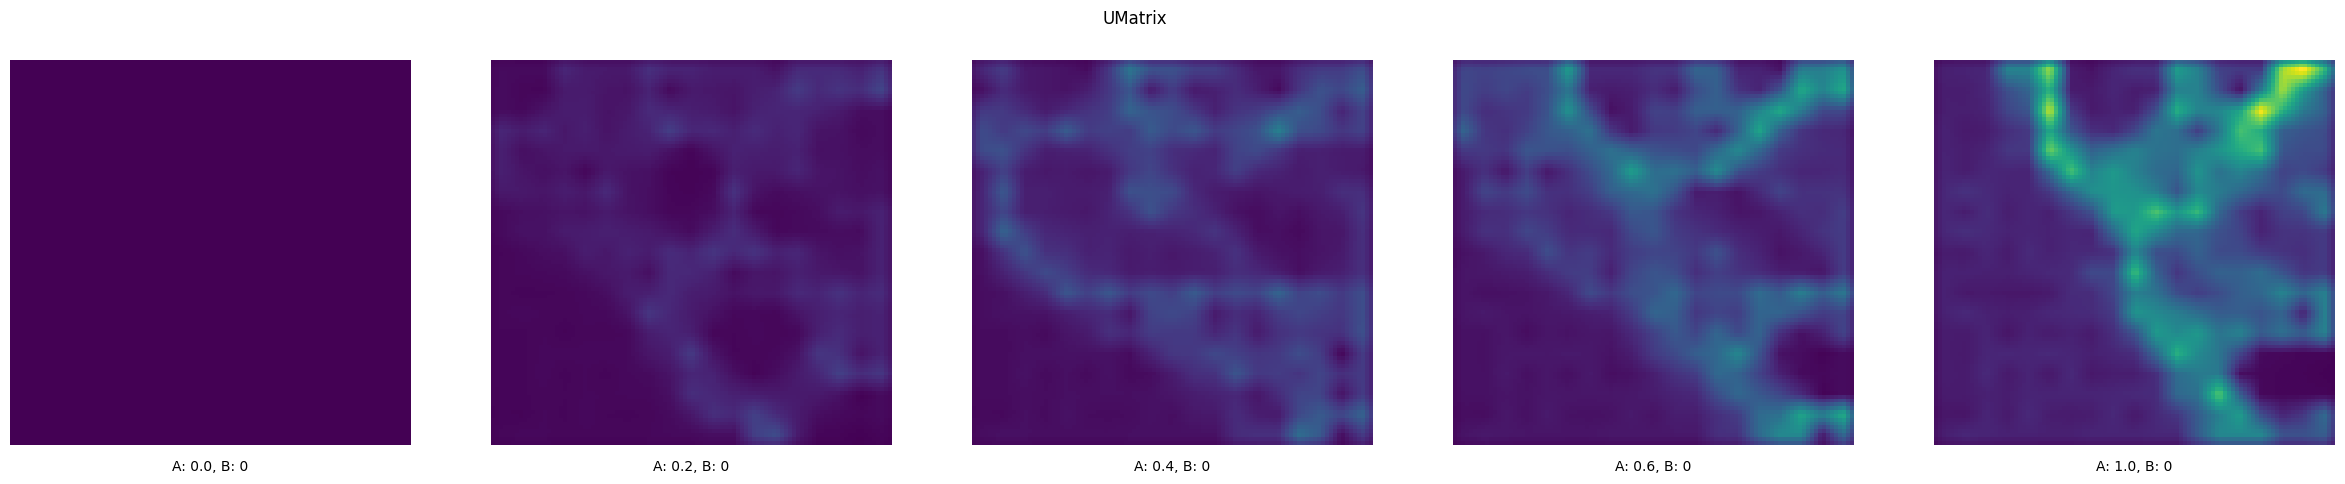

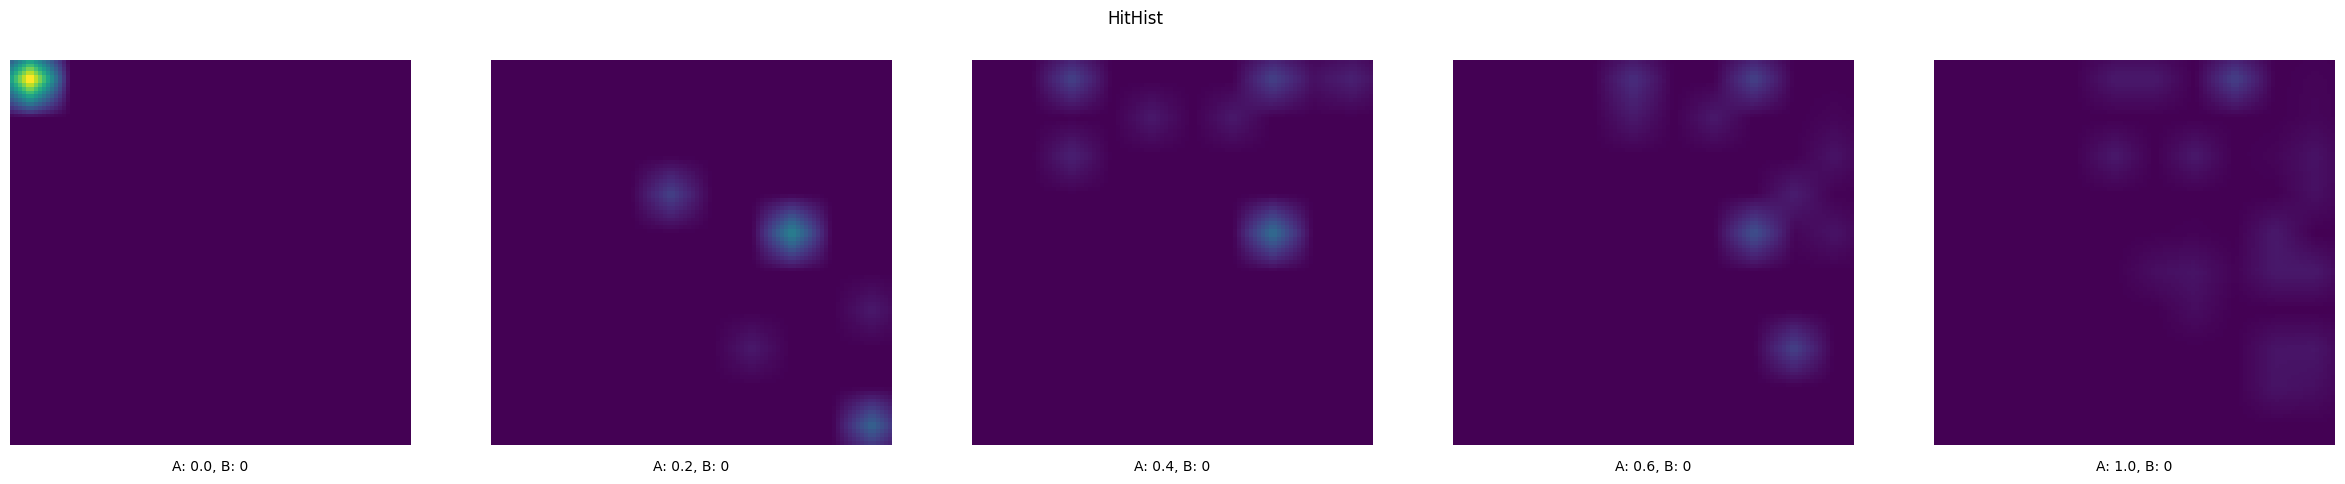

In [22]:
asom_small_8 = setup(
    som_dim=SOM_DIM,
    num_layers=6,
    aspect_selection=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# 100x60 Alignd SOMs on 10 Clusters dataset

In [23]:
SOM_DIM = (100, 60)
N_LAYERS = 31
ASPECT_SELECTION = [1, 1, 1, 1, 1, 1, 1, 0, 0, 0]

### Default Setup

In [24]:
asom_large_1 = setup(
    som_dim=SOM_DIM,
    num_layers=N_LAYERS,
    aspect_selection=ASPECT_SELECTION)

### Many In-Between Layers

In [ ]:
asom_large_2 = setup(
    som_dim=SOM_DIM,
    num_layers=128,
    aspect_selection=ASPECT_SELECTION)

### Strong Layer-Wise Coupling

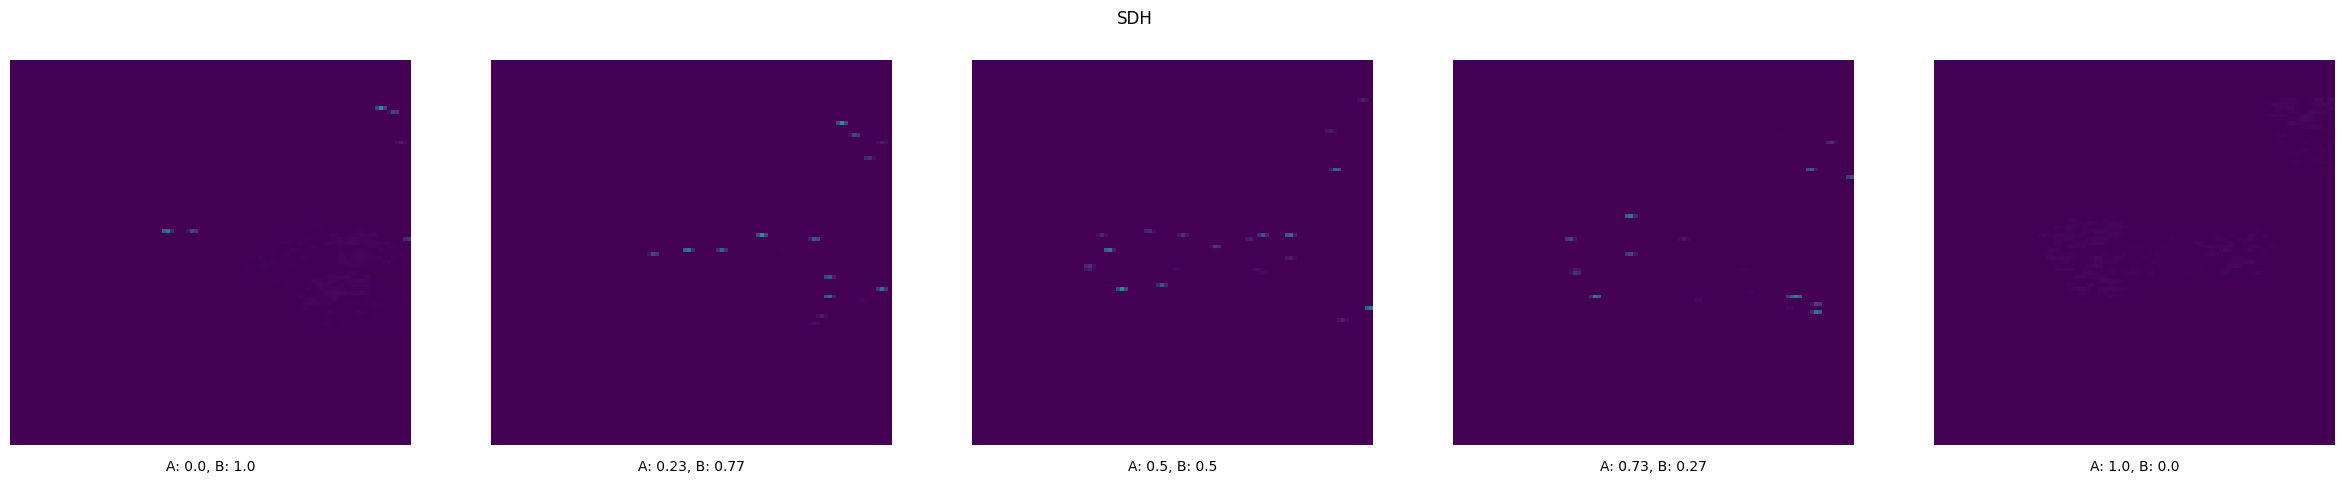

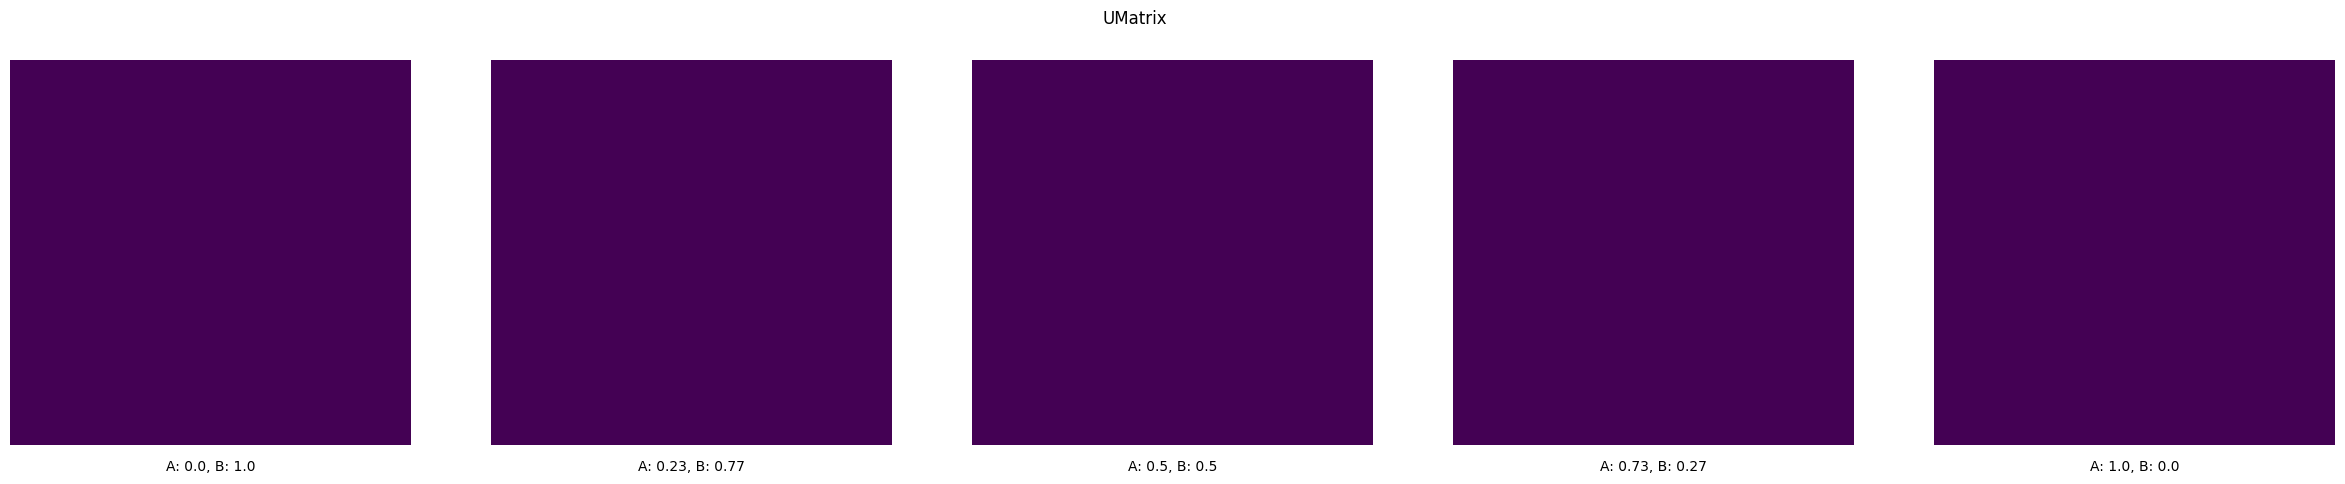

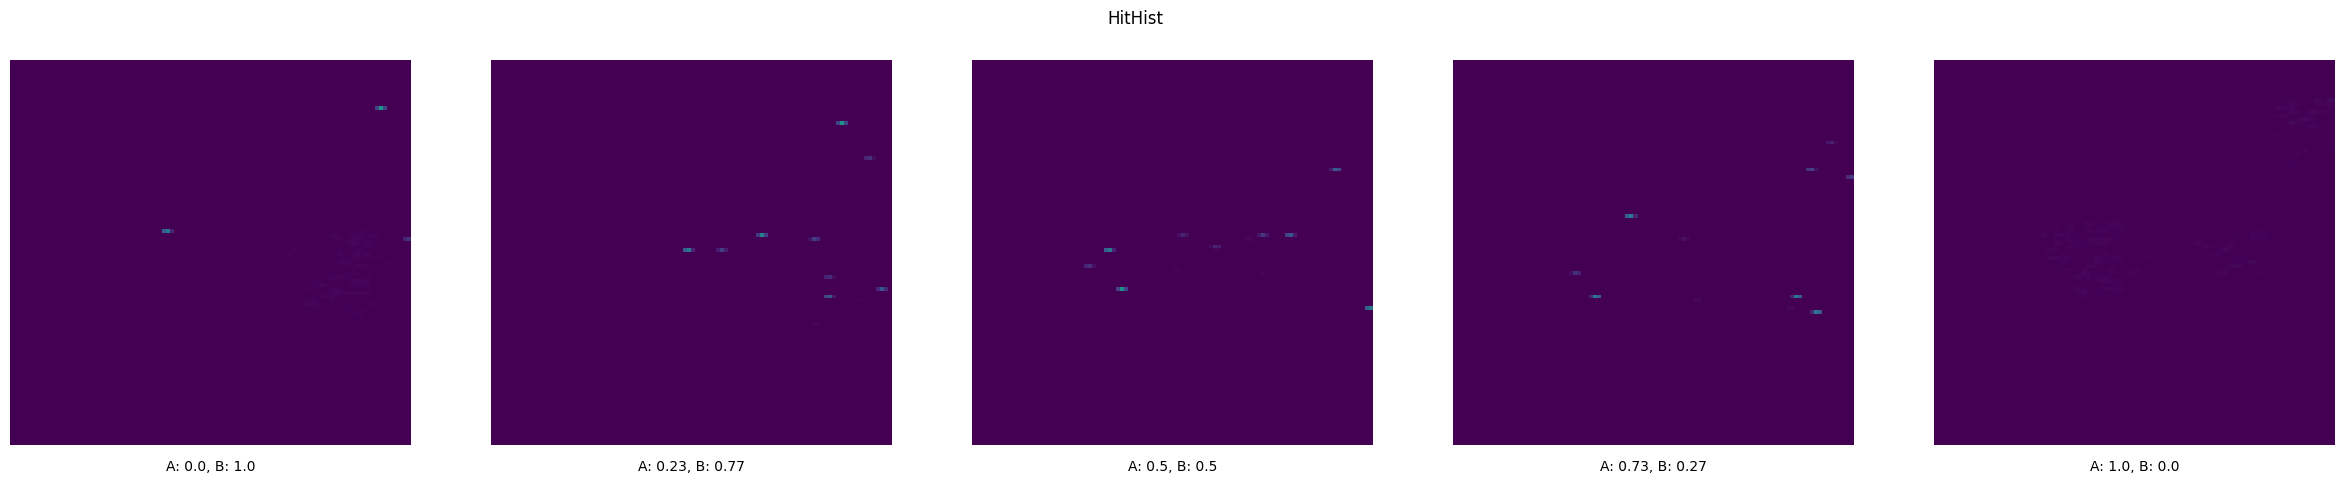

In [ ]:
asom_large_3 = setup(
    som_dim=SOM_DIM,
    num_layers=N_LAYERS,
    aspect_selection=ASPECT_SELECTION,
    layer_distance_ratio=10)


### Weak Layer-Wise Coupling

In [ ]:
asom_large_4 = setup(
    som_dim=SOM_DIM,
    num_layers=N_LAYERS,
    aspect_selection=ASPECT_SELECTION,
    layer_distance_ratio=1e-3)

### Few In-Between Layers

In [ ]:
asom_large_5 = setup(
    som_dim=SOM_DIM,
    num_layers=N_LAYERS,
    aspect_selection=ASPECT_SELECTION,
    num_layers=6)

### Switch Aspect Indices

In [ ]:
asom_large_6 = setup(
    som_dim=SOM_DIM,
    num_layers=N_LAYERS,
    aspect_selection=[0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

### Only Aspect A

In [ ]:
asom_large_7 = setup(
    som_dim=SOM_DIM,
    num_layers=N_LAYERS,
    aspect_selection=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Only Aspect  B

In [ ]:
asom_large_8 = setup(
    som_dim=SOM_DIM,
    num_layers=N_LAYERS,
    aspect_selection=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1])